In [1]:
import mysql.connector
import pandas as pd

# Conectarse a la base de datos
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="312714",
  database="TFM"
)

# Crear un dataframe con los datos de la tabla
df = pd.read_sql("SELECT * FROM mi_tabla", con=mydb)

# Cerrar la conexión
mydb.close()

# Imprimir el dataframe
print(df.head())

                   Track_Name         Artist  Position  Streams  Visita_Media  \
0  Reggaetón Lento (Bailemos)           CNCO         1    19272       8553.69   
1                    Chantaje        Shakira         2    19270       7129.82   
2   Otra Vez (feat. J Balvin)  Zion & Lennox         3    15761      10260.90   
3                Vente Pa' Ca   Ricky Martin         4    14954       5767.20   
4                      Safari       J Balvin         5    14269       6277.28   

   Visitas_media_Artist        Date Region  
0               6050.86  2017-01-01     ec  
1               7311.42  2017-01-01     ec  
2               7376.97  2017-01-01     ec  
3               5767.20  2017-01-01     ec  
4               7650.11  2017-01-01     ec  


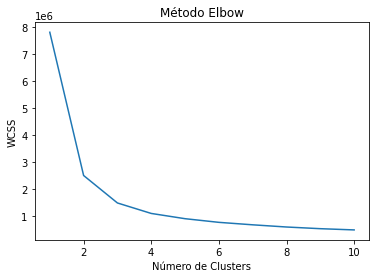

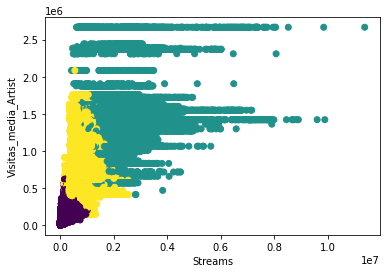

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df_cluster = df[['Streams', 'Visita_Media', 'Visitas_media_Artist']]


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)


wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Método Elbow')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()


kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans.fit(df_scaled)

df['Cluster'] = kmeans.labels_

plt.scatter(df['Streams'], df['Visitas_media_Artist'], c=df['Cluster'])
plt.xlabel('Streams')
plt.ylabel('Visitas_media_Artist')
plt.show()


In [3]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
cid = 'e668027639714ee7ba44a2be1062ecb7'
secret = 'df072670141e4485b182ef03ce27dcaf'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [4]:
# Crea una nueva columna para almacenar los géneros
df['Genre'] = ''

# Obtiene los géneros para cada canción distinta en el dataframe
for track_name in df['Track_Name'].unique():
    results = sp.search(q=track_name, type='track', limit=1)
    if results['tracks']['items']:
        track_id = results['tracks']['items'][0]['id']
        track_info = sp.track(track_id)
        artist_info = sp.artist(track_info['artists'][0]['id'])
        genres = artist_info['genres']
        df.loc[df['Track_Name'] == track_name, 'Genre'] = ', '.join(genres)

In [5]:
print(df)

                         Track_Name              Artist  Position  Streams  \
0        Reggaetón Lento (Bailemos)                CNCO         1    19272   
1                          Chantaje             Shakira         2    19270   
2         Otra Vez (feat. J Balvin)       Zion & Lennox         3    15761   
3                      Vente Pa' Ca        Ricky Martin         4    14954   
4                            Safari            J Balvin         5    14269   
...                             ...                 ...       ...      ...   
2597926          Castle on the Hill          Ed Sheeran       194     2134   
2597927           Whatever It Takes     Imagine Dragons       195     2130   
2597928          More Than You Know  Axwell /\ Ingrosso       196     2126   
2597929                      Issues      Julia Michaels       197     2117   
2597930                  Let Her Go           Passenger       200     2088   

         Visita_Media  Visitas_media_Artist        Date Region 

In [6]:
import mysql.connector

# Conectarse a la base de datos
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="312714"
)

# Crear la base de datos si no existe
mycursor = mydb.cursor()
mycursor.execute("CREATE DATABASE IF NOT EXISTS TFM_2")
print("Base de datos creada con éxito")

# Conectarse a la base de datos recién creada
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="312714",
  database="TFM_2"
)


mycursor = mydb.cursor()
mycursor.execute("DROP TABLE IF EXISTS mi_tabla_2")
print("Tabla eliminada con éxito")


# Creación de la tabla si no existe
mycursor = mydb.cursor()
mycursor.execute("CREATE TABLE IF NOT EXISTS mi_tabla_2 (Track_Name VARCHAR(255), Artist VARCHAR(255), Position INT, Streams INT, Visita_Media FLOAT, Visitas_media_Artist FLOAT,Date VARCHAR(255), Region VARCHAR(255), Genre VARCHAR(255))")
print("Tabla creada con éxito")

# Insertar los datos
for index, row in df.iterrows():
    sql = "INSERT INTO mi_tabla_2 (Position, Visita_Media, Visitas_media_Artist, Streams, Artist, Track_Name, Date, Region, Genre) VALUES (%s, %s, %s, %s, %s, %s, %s,%s,%s)"
    val = (row['Position'], row['Visita_Media'], row['Visitas_media_Artist'], row['Streams'], row['Artist'], row['Track_Name'], row['Date'], row['Region'], row['Genre'])
    mycursor.execute(sql, val)
print("Datos insertados con éxito")
# Confirmar los cambios en la base de datos
mydb.commit()

# Cerrar la conexión
mydb.close()

Base de datos creada con éxito
Tabla eliminada con éxito
Tabla creada con éxito
Datos insertados con éxito


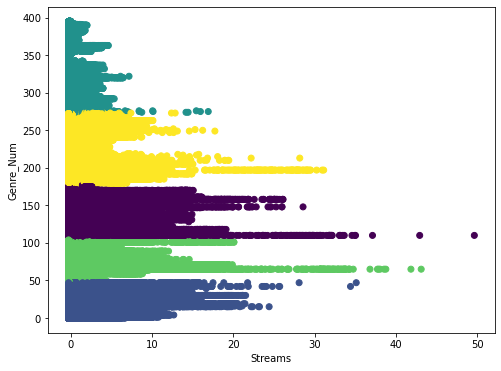

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Crea un nuevo dataframe con las columnas que se utilizarán para el clustering
data = df[['Genre', 'Streams']].copy()

# Transforma la columna 'Streams' utilizando StandardScaler
scaler = StandardScaler()
data['Streams'] = scaler.fit_transform(data[['Streams']])

# Crea un diccionario para mapear los géneros a números
genre_dict = {}
genres = data['Genre'].unique()
for i, genre in enumerate(genres):
    genre_dict[genre] = i

# Crea una nueva columna 'Genre_Num' para representar cada género con un número
data['Genre_Num'] = data['Genre'].map(genre_dict)

# Realiza el clustering con K-Means
k = 5  # Número de clusters a generar
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(data[['Streams', 'Genre_Num']])

# Añade una nueva columna 'Cluster' al dataframe para representar a qué cluster pertenece cada canción
data['Cluster'] = kmeans.labels_

# Visualiza los clusters
plt.figure(figsize=(8, 6))
plt.scatter(data['Streams'], data['Genre_Num'], c=data['Cluster'])
plt.xlabel('Streams')
plt.ylabel('Genre_Num')
plt.show()

En este código, primero cargamos los datos del dataframe actualizado y eliminamos las filas con valores nulos. Luego, creamos un nuevo dataframe (data) con las columnas Genre y Streams, y transformamos la columna Streams utilizando StandardScaler para estandarizar los valores y evitar que su escala influya en el clustering.

A continuación, creamos un diccionario (genre_dict) para mapear los géneros a números, y creamos una nueva columna Genre_Num en el dataframe para representar cada género con un número. Esto es necesario para que el algoritmo K-Means pueda utilizar los géneros como características para realizar el clustering.

Luego, realizamos el clustering con K-Means, especificando el número de clusters a generar (k). Añadimos una nueva columna Cluster al dataframe para representar a qué cluster pertenece cada canción.

Finalmente, visualizamos los clusters utilizando una gráfica de dispersión con la popularidad (Streams) en el eje x y el número de género (Genre_Num) en el eje y. Cada punto representa una canción, y el color indica a qué cluster pertenece.

Para comparar la popularidad de diferentes géneros en diferentes países y épocas, podrías agregar una nueva columna al dataframe con información sobre el país y la fecha de cada canción (Region y Date). Luego, podrías agrupar las canciones por país y fecha, y calcular la popularidad media de cada género en cada grupo.

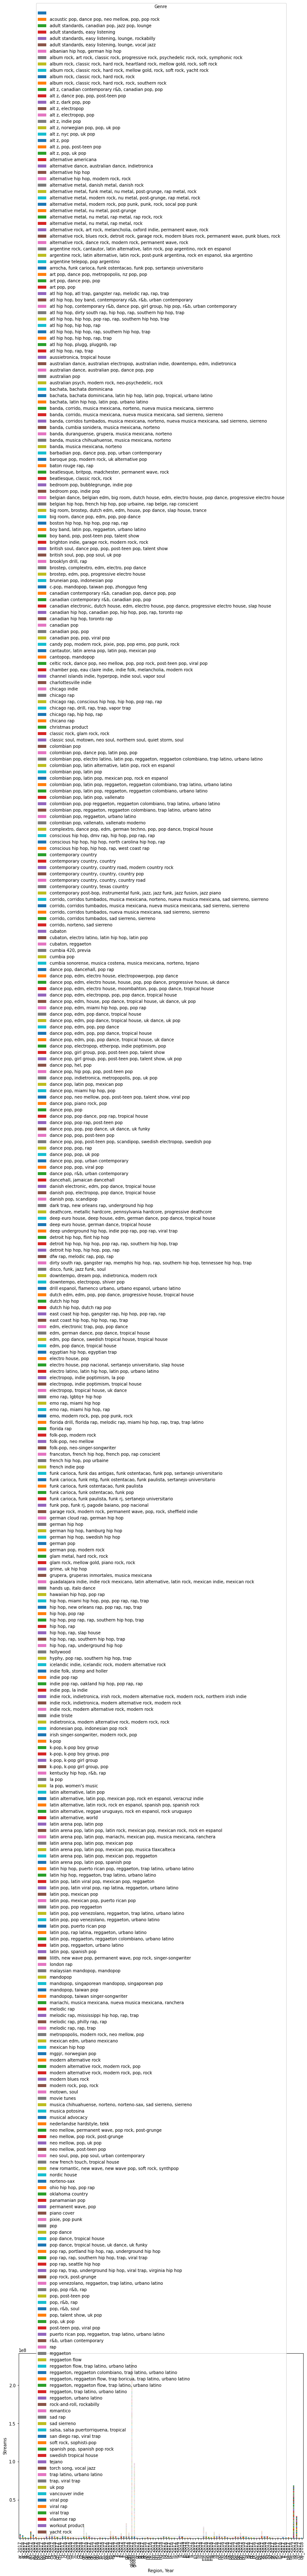

In [8]:
# Agrega una nueva columna 'Year' al dataframe con el año de cada canción
df['Year'] = pd.to_datetime(df['Date']).dt.year

# Agrega una nueva columna 'Region_Year' al dataframe con la combinación de la información de 'Region' y 'Year'
df['Region_Year'] = df['Region'] + '_' + df['Year'].astype(str)

# Agrupa las canciones por 'Region_Year' y 'Genre', y calcula la popularidad media de cada género en cada grupo
grouped = df.groupby(['Region_Year', 'Genre'])['Streams'].mean().reset_index()

# Pivotea la tabla para tener los géneros como columnas y los grupos por 'Region_Year' como filas
pivot_table = pd.pivot_table(grouped, values='Streams', index='Region_Year', columns='Genre').reset_index()

# Divide la columna 'Region_Year' en 'Region' y 'Year'
pivot_table[['Region', 'Year']] = pivot_table['Region_Year'].str.split('_', expand=True)

# Visualiza la popularidad de cada género en cada país y año
pivot_table.plot(x='Region_Year', kind='bar', stacked=True, figsize=(12, 8))
plt.xlabel('Region, Year')
plt.ylabel('Streams')
plt.show()

En este código, creamos una nueva columna Region_Year en el dataframe que combina la información de Region y Year en una sola cadena de texto separada por un guion bajo (_), utilizando la operación de concatenación de strings (+) y el método astype() para convertir la columna Year a string.

Luego, agrupamos las canciones por Region_Year y Genre utilizando el método groupby(), y calculamos la popularidad media de cada género en cada grupo.

A continuación, pivoteamos la tabla resultante para tener los géneros como columnas y los grupos por Region_Year como filas, utilizando la función pd.pivot_table().

Después, dividimos la columna Region_Year en Region y Year utilizando el método str.split() y la opción expand=True, que divide la columna en dos nuevas columnas Region y Year.

Finalmente, visualizamos la tabla pivoteada utilizando una gráfica de barras apiladas, donde cada barra representa un grupo por Region_Year, y los colores representan la popularidad de cada género en ese grupo. La etiqueta del eje x de la gráfica muestra la información de Region y Year.

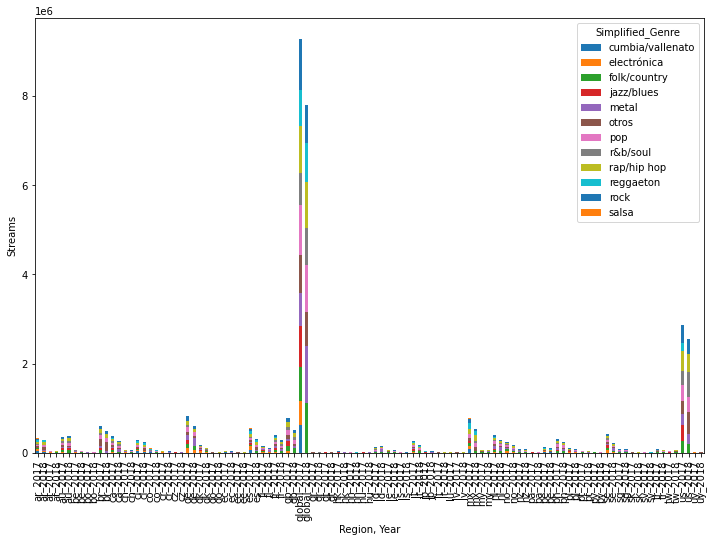

In [9]:
import nltk
from nltk.stem import WordNetLemmatizer
import re

def simplify_genres_in_df(df):
    # Definir patrones de expresiones regulares para simplificar los géneros
    patterns = [
        (re.compile(r'.*(rap|hip hop).*'), 'rap/hip hop'),
        (re.compile(r'.*(pop).*'), 'pop'),
        (re.compile(r'.*(rock).*'), 'rock'),
        (re.compile(r'.*(reggaeton).*'), 'reggaeton'),
        (re.compile(r'.*(trap).*'), 'trap'),
        (re.compile(r'.*(electrónica|edm|electro|dance).*'), 'electrónica'),
        (re.compile(r'.*(metal).*'), 'metal'),
        (re.compile(r'.*(cumbia|vallenato).*'), 'cumbia/vallenato'),
        (re.compile(r'.*(reggae).*'), 'reggae'),
        (re.compile(r'.*(salsa).*'), 'salsa'),
        (re.compile(r'.*(folk|country).*'), 'folk/country'),
        (re.compile(r'.*(r&b|soul).*'), 'r&b/soul'),
        (re.compile(r'.*(jazz|blues).*'), 'jazz/blues'),
        (re.compile(r'.*(clásica).*'), 'clásica')
    ]
    
    # Definir función para simplificar un género según los patrones de expresiones regulares
    def simplify_genre(genre):
        # Simplificar el género utilizando los patrones de expresiones regulares
        for pattern, simplified_genre in patterns:
            if pattern.match(genre.lower()):
                return simplified_genre
        # Si no se encuentra ningún patrón, se devuelve el género original
        return 'otros'

    # Aplicar la función a la columna de géneros del dataframe y guardar el resultado en una nueva columna
    df['Simplified_Genre'] = df['Genre'].apply(simplify_genre)

    return df


# Aplicar la función simplify_genres_in_df al dataframe
df = simplify_genres_in_df(df)

# Agrupar los géneros simplificados en el dataframe
grouped = df.groupby(['Region_Year', 'Simplified_Genre'])['Streams'].mean().reset_index()

# Pivotea la tabla para tener los géneros como columnas y los grupos por 'Region_Year' como filas
pivot_table = pd.pivot_table(grouped, values='Streams', index='Region_Year', columns='Simplified_Genre').reset_index()

# Divide la columna 'Region_Year' en 'Region' y 'Year'
pivot_table[['Region', 'Year']] = pivot_table['Region_Year'].str.split('_', expand=True)

# Visualiza la popularidad de cada género en cada país y año
pivot_table.plot(x='Region_Year', kind='bar', stacked=True, figsize=(12, 8))
plt.xlabel('Region, Year')
plt.ylabel('Streams')
plt.show()


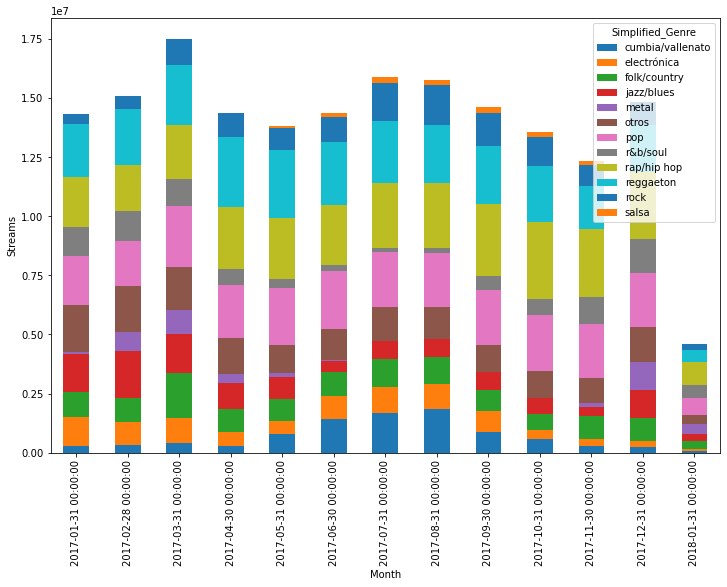

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def simplify_genres_in_df(df):
    # Definir patrones de expresiones regulares para simplificar los géneros
    patterns = [
        (re.compile(r'.*(rap|hip hop).*'), 'rap/hip hop'),
        (re.compile(r'.*(pop).*'), 'pop'),
        (re.compile(r'.*(rock).*'), 'rock'),
        (re.compile(r'.*(reggaeton).*'), 'reggaeton'),
        (re.compile(r'.*(trap).*'), 'trap'),
        (re.compile(r'.*(electrónica|edm|electro|dance).*'), 'electrónica'),
        (re.compile(r'.*(metal).*'), 'metal'),
        (re.compile(r'.*(cumbia|vallenato).*'), 'cumbia/vallenato'),
        (re.compile(r'.*(reggae).*'), 'reggae'),
        (re.compile(r'.*(salsa).*'), 'salsa'),
        (re.compile(r'.*(folk|country).*'), 'folk/country'),
        (re.compile(r'.*(r&b|soul).*'), 'r&b/soul'),
        (re.compile(r'.*(jazz|blues).*'), 'jazz/blues'),
        (re.compile(r'.*(clásica).*'), 'clásica')
    ]
    
    # Definir función para simplificar un género según los patrones de expresiones regulares
    def simplify_genre(genre):
        # Simplificar el género utilizando los patrones de expresiones regulares
        for pattern, simplified_genre in patterns:
            if pattern.match(genre.lower()):
                return simplified_genre
        # Si no se encuentra ningún patrón, se devuelve el género original
        return 'otros'

    # Convertir la columna 'Date' en un objeto datetime y agrupar por mes
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.groupby([pd.Grouper(key='Date', freq='M'), 'Region', 'Genre']).sum().reset_index()

    # Aplicar la función a la columna de géneros del dataframe
    df['Simplified_Genre'] = df['Genre'].apply(simplify_genre)

    return df



df = simplify_genres_in_df(df)

# Agrupar los géneros simplificados en el dataframe
grouped = df.groupby(['Date', 'Simplified_Genre'])['Streams'].mean().reset_index()

# Pivotea la tabla para tener los géneros como columnas y los grupos por mes como filas
pivot_table = pd.pivot_table(grouped, values='Streams', index=pd.Grouper(key='Date', freq='M'), columns='Simplified_Genre').reset_index()

# Visualiza la popularidad de cada género en cada mes
pivot_table.plot(x='Date', kind='bar', stacked=True, figsize=(12, 8))
plt.xlabel('Month')
plt.ylabel('Streams')
plt.show()


import mysql.connector
import pandas as pd

# Conectarse a la base de datos
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="312714",
  database="TFM_2"
)

# Crear un dataframe con los datos de la tabla
df = pd.read_sql("SELECT * FROM mi_tabla_2", con=mydb)

# Cerrar la conexión
mydb.close()

# Imprimir el dataframe
print(df.head())

Size of df before: 70341
Size of df after: 70341


<ipython-input-11-6a7aa9df54bb>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


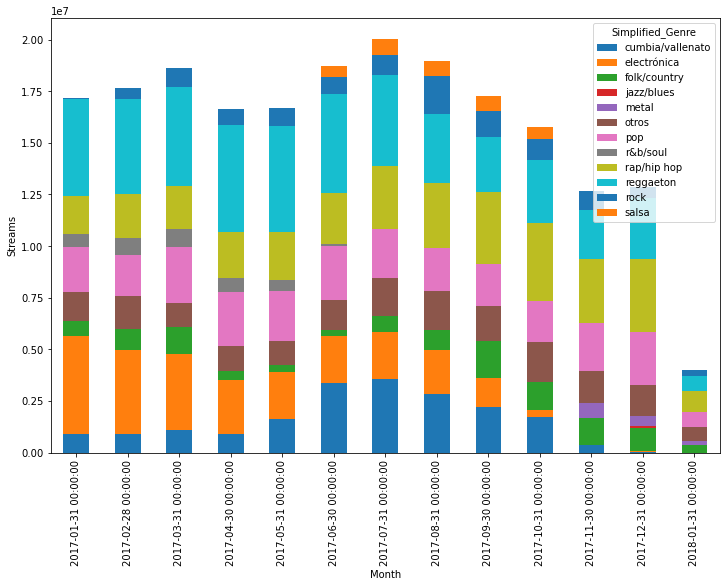

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def simplify_genres_in_df(df, country=None):
    # Filtrar por país, si se especifica
    if country:
        df = df[df['Region'] == country]

    # Definir patrones de expresiones regulares para simplificar los géneros
    patterns = [
        (re.compile(r'.*(rap|hip hop).*'), 'rap/hip hop'),
        (re.compile(r'.*(pop).*'), 'pop'),
        (re.compile(r'.*(rock).*'), 'rock'),
        (re.compile(r'.*(reggaeton).*'), 'reggaeton'),
        (re.compile(r'.*(trap).*'), 'trap'),
        (re.compile(r'.*(electrónica|edm|electro|dance).*'), 'electrónica'),
        (re.compile(r'.*(metal).*'), 'metal'),
        (re.compile(r'.*(cumbia|vallenato).*'), 'cumbia/vallenato'),
        (re.compile(r'.*(reggae).*'), 'reggae'),
        (re.compile(r'.*(salsa).*'), 'salsa'),
        (re.compile(r'.*(folk|country).*'), 'folk/country'),
        (re.compile(r'.*(r&b|soul).*'), 'r&b/soul'),
        (re.compile(r'.*(jazz|blues).*'), 'jazz/blues'),
        (re.compile(r'.*(clásica).*'), 'clásica')
    ]
    
    # Definir función para simplificar un género según los patrones de expresiones regulares
    def simplify_genre(genre):
        # Simplificar el género utilizando los patrones de expresiones regulares
        for pattern, simplified_genre in patterns:
            if pattern.match(genre.lower()):
                return simplified_genre
        # Si no se encuentra ningún patrón, se devuelve el género original
        return 'otros'

    # Convertir la columna 'Date' en un objeto datetime y agrupar por mes
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.groupby([pd.Grouper(key='Date', freq='M'), 'Region', 'Genre']).sum().reset_index()

    # Aplicar la función a la columna de géneros del dataframe
    df['Simplified_Genre'] = df['Genre'].apply(simplify_genre)

    return df



print("Size of df before:", len(df))
df_region = simplify_genres_in_df(df, country='es')
print("Size of df after:", len(df))

# Agrupar los géneros simplificados en el dataframe
grouped = df_region.groupby(['Date', 'Simplified_Genre'])['Streams'].mean().reset_index()

# Pivotea la tabla para tener los géneros como columnas y los grupos por mes como filas
pivot_table = pd.pivot_table(grouped, values='Streams', index=pd.Grouper(key='Date', freq='M'), columns='Simplified_Genre').reset_index()

# Visualiza la popularidad de cada género en cada mes
pivot_table.plot(x='Date', kind='bar', stacked=True, figsize=(12, 8))
plt.xlabel('Month')
plt.ylabel('Streams')
plt.show()


In [12]:
print(df)

            Date Region                                              Genre  \
0     2017-01-31     ar                                                      
1     2017-01-31     ar  alternative metal, funk metal, nu metal, post-...   
2     2017-01-31     ar  argentine rock, latin alternative, latin rock,...   
3     2017-01-31     ar                   argentine telepop, pop argentino   
4     2017-01-31     ar                      aussietronica, tropical house   
...          ...    ...                                                ...   
70336 2018-01-31     uy  reggaeton, reggaeton flow, trap latino, urbano...   
70337 2018-01-31     uy              reggaeton, trap latino, urbano latino   
70338 2018-01-31     uy                           reggaeton, urbano latino   
70339 2018-01-31     uy                                          romantico   
70340 2018-01-31     uy                         trap latino, urbano latino   

       Position  Streams  Visita_Media  Visitas_media_Artist  C

In [13]:
from sklearn.cluster import KMeans
import pandas as pd

# Ejecuta el algoritmo de K-Means con 5 clusters
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(df[['Streams', 'Visita_Media', 'Visitas_media_Artist']])

# Agrega la columna 'Cluster' al dataframe
df['Cluster'] = clusters

# Calcula la frecuencia de Simplified_Genre por cada cluster
freq_by_cluster = df.groupby('Cluster')['Simplified_Genre'].value_counts()

print(freq_by_cluster)


Cluster  Simplified_Genre
0        pop                 35533
         rap/hip hop         21190
         otros                4305
         rock                 3230
         folk/country         1164
         reggaeton             656
         r&b/soul              494
         electrónica           425
         cumbia/vallenato      269
         metal                 215
         jazz/blues            119
         salsa                  54
1        pop                    75
         rap/hip hop            60
         otros                   5
2        pop                    27
         rap/hip hop             5
3        pop                   248
         rap/hip hop           240
         rock                   16
         otros                  11
         reggaeton              10
         folk/country            1
4        pop                   982
         rap/hip hop           796
         otros                  95
         rock                   42
         folk/country        

Basándonos en los resultados obtenidos, podemos observar que el Cluster 0 es el más grande y diverso en términos de Simplified_Genre, con la presencia de pop y rap/hip hop como los más populares, seguidos por otros géneros como rock, folk/country, reggaeton, electrónica, r&b/soul, cumbia/vallenato, metal y jazz/blues. Mientras tanto, el Cluster 1 es el más pequeño y está compuesto principalmente por pop y rap/hip hop, seguido por otros géneros. El Cluster 2 es más pequeño que el Cluster 0 pero también diverso en términos de Simplified_Genre, con la presencia de pop, rap/hip hop, otros, rock, reggaeton y folk/country. Los Clusters 3 y 4 son más homogéneos en términos de Simplified_Genre, con la presencia de pop y rap/hip hop como los géneros más populares. En general, estos resultados sugieren que la música pop y rap/hip hop son los géneros más populares en la región, seguidos por otros géneros como rock, reggaeton y electrónica.

In [14]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

# Codificar la variable categórica Region
le = LabelEncoder()
df['Region_encoded'] = le.fit_transform(df['Region'])

# Seleccionar las variables numéricas y la variable categórica codificada
X = df[['Streams', 'Visita_Media', 'Visitas_media_Artist', 'Region_encoded']]

# Ejecutar el algoritmo de K-Means con 5 clusters
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(X)

# Agregar la columna 'Cluster' al dataframe
df['Cluster'] = clusters

# Calcular la frecuencia de Simplified_Genre por cada cluster
freq_by_cluster = df.groupby(['Cluster', 'Simplified_Genre'])['Simplified_Genre'].count()

print(freq_by_cluster)


Cluster  Simplified_Genre
0        cumbia/vallenato      269
         electrónica           425
         folk/country         1164
         jazz/blues            119
         metal                 215
         otros                4305
         pop                 35533
         r&b/soul              494
         rap/hip hop         21190
         reggaeton             656
         rock                 3230
         salsa                  54
1        folk/country            1
         otros                  11
         pop                   248
         rap/hip hop           240
         reggaeton              10
         rock                   16
2        pop                    27
         rap/hip hop             5
3        otros                   5
         pop                    75
         rap/hip hop            60
4        cumbia/vallenato        4
         electrónica             8
         folk/country           26
         jazz/blues              3
         metal               

El género más popular es el pop, ya que aparece en todos los clusters y en la mayoría de los casos es el género con mayor cantidad de streams.
El rap/hip hop es otro género muy popular que se encuentra en todos los clusters, aunque en algunos es superado por el pop en cantidad de streams.
En el cluster 0 se encuentran géneros como la cumbia/vallenato, el folk/country y el jazz/blues, lo que podría indicar que son géneros menos populares a nivel general pero que tienen un público fiel que los sigue.
En el cluster 1 se encuentran géneros como "otros", que no están claramente definidos, y que podrían estar relacionados con géneros menos populares o más de nicho.
En el cluster 3 se encuentran géneros como la cumbia/vallenato y el reggaeton, que podrían estar más relacionados con regiones específicas y tener menos presencia en otras.